# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can such serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 30
BATCH_SIZE = 256
SEQ_LEN = 60
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(74421, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=74421, bias=True)
)

This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [5]:
train_losses, val_losses, best_checkpoint = rnn.train(
    model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

epoch 9 training loss = 4.5672: 100%|██████████| 166/166 [07:43<00:00,  2.79s/it]



best model:
|-- epoch: 7
|-- validation loss: 5.0768


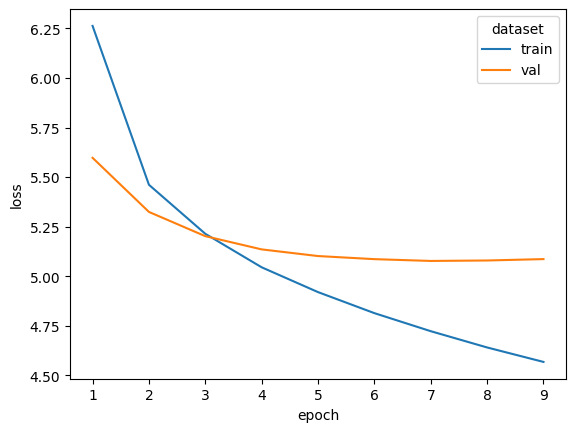

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-07-15T14:16:25;loss=4_9435.pt


Then set a prompt.

In [8]:
prompt = "Now I love horror, but I found this"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.

In [9]:
text = rnn.generate(best_model, prompt, datasets.tokenizer, "greedy", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie is and movie that you can see. The plot is
horrible a the plot is horrible. The plot is horrible a the hes is camera. The plot is
horrible a the hes is camera. The plot is horrible a the hes is camera. The plot is
horrible a the hes is camera. The...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=3).

In [10]:
text = rnn.generate(
    best_model, prompt, datasets.tokenizer, "topk", temperature=1.0, k=3
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie is not and movie that you other not forth
it. I have character this movie on different I would couple it. Has you are and distrust
wont be real it but you dont have and happen to see the comedy. It was and good film. It
was the rather movie I have does character....


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [11]:
text = rnn.generate(best_model, prompt, datasets.tokenizer, "sample", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS to even women cant so angst doing in this movie a
now teen on and story so in and low drugs barbarians also the missing a version a
lighting in acting down bored. Like it was bottom up commercials and right course. It is
not more gift home guess is to beyond an attempt music and mike present...


### Benchmark

Compare all output with that from an untrained model.

In [12]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", temperature=1.0
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS rosie brussels moonshine feels lamenting
seniority honks puller commanded fenian divulges parasite lessens pommel mcdonalds
plymouth escapist robberies explicate denying mean maggi maggi mongers moonshine
graverobbers croaks deadlier winfield friction hudkins hollywoodized zinta mclachlan
lipscomb doctors recesses recesses tethers columbine impersonate totally feeble jughead
zillion accumulated ferrot decadence den siege buggy navelgazer poderoso lee solutions
nonentities enabler heartbroken bloodshot convolutions...
